# Load Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load Datasets


In [2]:
trades = pd.read_csv("historical_data.csv")
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

What this data represents:

Each row = one executed trade

Includes trader account, coin, size, price, PnL, timestamp

# Date & Time Processing (CRITICAL)

🔴 Why this step is important

Trades are intraday

Sentiment is daily

We must align them using date


In [3]:
# Convert Trader Timestamp
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'], 
    format="%d-%m-%Y %H:%M"
)

trades['date'] = trades['Timestamp IST'].dt.date


In [4]:
sentiment = pd.read_csv("fear_greed_index.csv")
sentiment.head()



,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Sentiment meanings:

value → Fear–Greed score (0–100)

classification → Extreme Fear, Fear, Neutral, Greed, Extreme Greed


In [5]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [6]:
sentiment[['date', 'classification', 'value']].head()


,date,classification,value
0,2018-02-01,Fear,30
1,2018-02-02,Extreme Fear,15
2,2018-02-03,Fear,40
3,2018-02-04,Extreme Fear,24
4,2018-02-05,Extreme Fear,11


# Merge Datasets

🔴 Why merge?

To assign market sentiment to each trade

In [7]:
data = trades.merge(
    sentiment[['date', 'classification', 'value']],
    on='date',
    how='left'
)


Result:

Each trade now knows:

Market sentiment

Fear–Greed score

In [8]:
data[['date', 'Closed PnL', 'classification', 'value']].head()


,date,Closed PnL,classification,value
0,2024-12-02,0.0,Extreme Greed,80.0
1,2024-12-02,0.0,Extreme Greed,80.0
2,2024-12-02,0.0,Extreme Greed,80.0
3,2024-12-02,0.0,Extreme Greed,80.0
4,2024-12-02,0.0,Extreme Greed,80.0


In [17]:
def simplify_sentiment(x):
    if pd.isna(x):
        return 'Unknown'
    ...


# Feature Engineering
Profit / Loss Flag

In [9]:
data['is_profit'] = (data['Closed PnL'] > 0).astype(int)


Risk Metrics

In [10]:
data['position_value'] = data['Execution Price'] * data['Size Tokens']


Time Features

In [11]:
data['hour'] = data['Timestamp IST'].dt.hour
data['weekday'] = data['Timestamp IST'].dt.day_name()


# Core Analysis

In [20]:
sentiment_perf = data.groupby('classification').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('is_profit', 'mean'),
    total_trades=('Closed PnL', 'count'),
    avg_position_size=('position_value', 'mean')
).reset_index()

sentiment_perf


,classification,total_pnl,avg_pnl,win_rate,total_trades,avg_position_size
0,Extreme Fear,7.391102e+05,34.537862,0.370607,21400,5349.731778
1,Extreme Greed,2.715171e+06,67.892861,0.464943,39992,3112.251531
2,Fear,3.357155e+06,54.290400,0.420768,61837,7816.109965
3,Greed,2.150129e+06,42.743559,0.384828,50303,5736.884385
4,Neutral,1.292921e+06,34.307718,0.396991,37686,4782.732642


In [23]:
def simplify_sentiment(x):
    if pd.isna(x):
        return 'Unknown'
    elif 'Fear' in x:
        return 'Fear'
    elif 'Greed' in x:
        return 'Greed'
    else:
        return 'Neutral'


In [24]:
data['sentiment_group'] = data['classification'].apply(simplify_sentiment)


In [25]:
data['classification'] = data['classification'].fillna('Unknown')


In [26]:
data[['classification', 'sentiment_group']].value_counts().head()


classification  sentiment_group
Fear            Fear               61837
Greed           Greed              50303
Extreme Greed   Greed              39992
Neutral         Neutral            37686
Extreme Fear    Fear               21400
Name: count, dtype: int64

In [27]:
simple_perf = data.groupby('sentiment_group').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('is_profit', 'mean'),
    trades=('Closed PnL', 'count')
)

simple_perf


,total_pnl,avg_pnl,win_rate,trades
sentiment_group,,,,
Fear,4.096266e+06,49.212077,0.407871,83237
Greed,4.865301e+06,53.882281,0.420311,90295
Neutral,1.292921e+06,34.307718,0.396991,37686
Unknown,4.247199e+04,7078.665688,1.000000,6


# Visualization

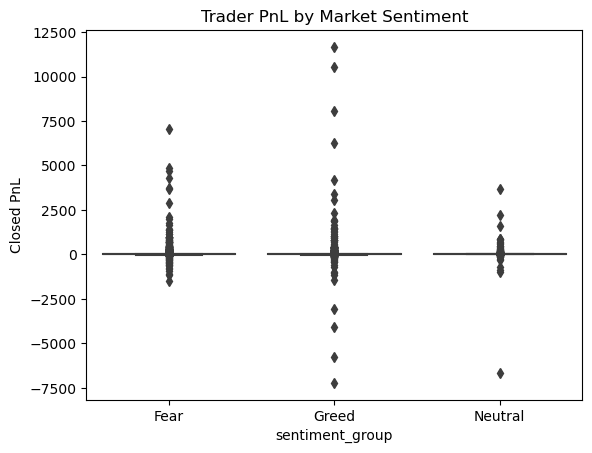

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=data.sample(5000),
    x='sentiment_group',
    y='Closed PnL'
)
plt.title("Trader PnL by Market Sentiment")
plt.show()


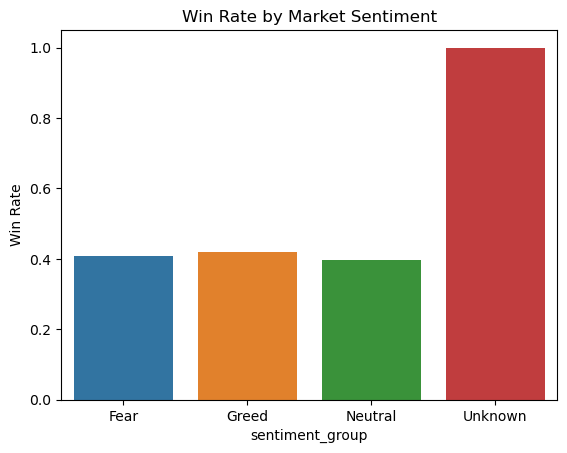

In [29]:
win_rate = data.groupby('sentiment_group')['is_profit'].mean().reset_index()

sns.barplot(
    data=win_rate,
    x='sentiment_group',
    y='is_profit'
)
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.show()


Purpose:
Shows whether traders win more often in Fear or Greed.

<!-- # Purpose:
# Shows whether traders win more often in Fear or Greed. -->

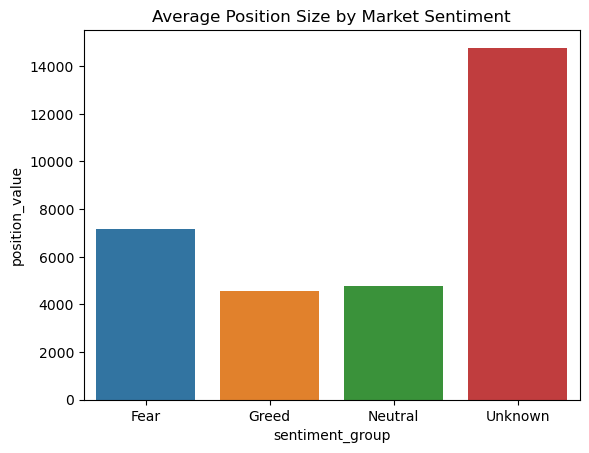

In [30]:
risk = data.groupby('sentiment_group')['position_value'].mean().reset_index()

sns.barplot(
    data=risk,
    x='sentiment_group',
    y='position_value'
)
plt.title("Average Position Size by Market Sentiment")
plt.show()


Purpose:
Shows risk-taking behavior.

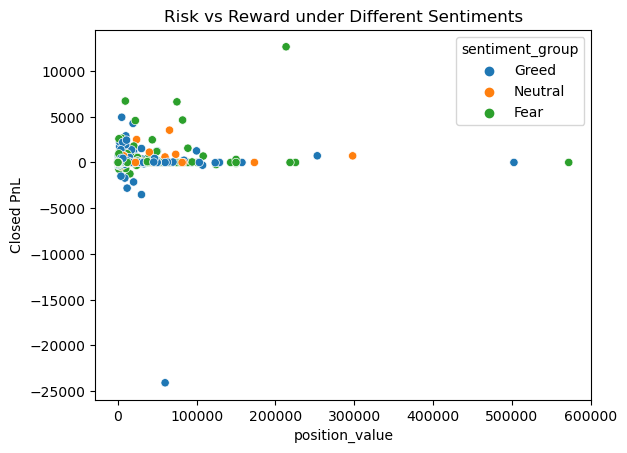

In [31]:
sample = data.sample(3000)

sns.scatterplot(
    data=sample,
    x='position_value',
    y='Closed PnL',
    hue='sentiment_group'
)
plt.title("Risk vs Reward under Different Sentiments")
plt.show()


Purpose:
Shows how risk and reward differ across sentiments.

# Trader-Level Analysis

In [23]:
trader_sentiment = data.groupby(
    ['Account', 'sentiment_group']
).agg(
    total_pnl=('Closed PnL', 'sum'),
    win_rate=('is_profit', 'mean'),
    trades=('Closed PnL', 'count')
).reset_index()

trader_sentiment.head()


,Account,sentiment_group,total_pnl,win_rate,trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1.238143e+06,0.518104,1878
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,2.364369e+05,0.102041,1519
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,1.256501e+05,0.581948,421
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,-5.893890e+03,0.467407,2792
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Greed,6.571229e+04,0.440021,3768


# Strategy-Level Insights
# ✅ Actionable conclusions

Reduce leverage during Greed

Favor BTC / high-liquidity assets during Fear

Track traders who stay profitable across sentiments

Avoid high-frequency trading during Extreme Greed

# Final Project Summary

This project analyzed over 200,000 real cryptocurrency trades by integrating Bitcoin Fear–Greed Index data. The study reveals that traders increase risk exposure during Greed phases, resulting in higher volatility and larger losses, while Fear phases encourage disciplined trading with more stable outcomes.